<a href="https://colab.research.google.com/github/DmitriiDenisov/research-DT-Logreg/blob/master/step_by_step_custom_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Step-by-step Example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin_slsqp
from scipy.optimize import minimize

In [2]:
def split(x, y, W): #y must be +/-1
  result = fmin_slsqp(func, W, bounds=[(-1000, 1000)]*len(W), args=(x, y), disp=False, full_output=True)
  Wopt, fW, its, imode, smode = result
  return Wopt

from scipy.stats import entropy
def entropy1(labels):
  value,counts = np.unique(labels, return_counts=True)
  return entropy(counts)

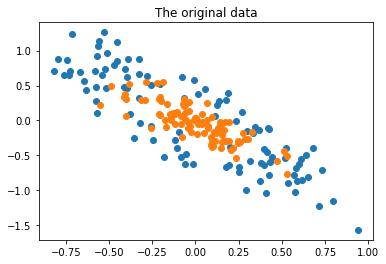

In [42]:
from sklearn.datasets import make_circles, make_moons, make_classification
np.random.seed(7)

X, y = make_circles(n_samples=200, noise=0.3, factor=0.2, )
transformation = [[0.6, -0.6], [-0.1, 0.6]]
X = np.dot(X, transformation)

plt.scatter(X[y==0][:,0], X[y==0][:,1])
plt.scatter(X[y==1][:,0], X[y==1][:,1])
plt.title('The original data')
plt.show()

In [43]:
class RTTree():
  def __init__(self):
    # Structure of JSON:
    # {'init_ent': float, 'new_ent': float, 'Wopt': [...], 'left': {...}, 'right': {...}}
    tree_struct = dict()

  @staticmethod
  def func(w, x, y):
    return np.mean(1 / (1 + np.exp(2.5 * y * np.dot(x, w))))

  @staticmethod
  def split(x, y, W): #y must be +/-1
    result = fmin_slsqp(func, W, bounds=[(-1000, 1000)]*len(W), args=(x, y), disp=False, full_output=True)
    Wopt, fW, its, imode, smode = result
    return Wopt
  
  def calculate_entropy(y, y_0, y_1):
    ent_left = entropy1(y_0)
    ent_right = entropy1(y_1)
    new_ent = (len(y_1)*ent_1 + len(y_0)*ent_0)/(len(y_1)+len(y_0))
    init_ent = entropy1(y)
    return init_ent, ent_0, ent_1, new_ent

  def fit_node(X, y, node_struct):
    # optimizator
    W_init = np.array([-0.1, -0.2, -0.1]) # think of optimal initialization
    Wopt = split(x, y, W)
    Wopt = np.array(Wopt)

    # predict
    y_pred = np.dot(X_train, Wopt) > 0
    y_pred[y_pred == 0] = -1 # convert 0 to -1

    #Split the data according to the predictions
    x_left = X_train[y_pred==-1]
    y_left = X_train[y_pred==-1]
    x_right = X_train[y_pred==1]
    y_right = X_train[y_pred==1]
    # b = Wopt[2]
    # m0 = Wopt[0]
    # m1 = Wopt[1]

    # entropy 
    init_ent, ent_left, ent_right, new_ent = calculate_entropy(y, y_left, y_right)

    # save to json
    node_struct['Wopt'] = Wopt
    if new_ent < init_ent:
      # tree_struct['init_ent'] = init_ent
      node_struct['new_ent'] = new_ent
      node_struct['left'] = dict()
      node_struct['left']['init_ent'] = ent_left
      node_struct['right'] = dict()
      node_struct['right']['init_ent'] = ent_right

      # recursion left
      res_left = fit_node(x_left, y_left, node_struct['left'])
      
      # recursion right
      res_right = fit_node(x_right, y_right, node_struct['right'])
    else:
      return False
    return True


  def fit(self, X_train: np.array, y_train: np.array):
    # prepare data
    X_train = np.c_[ X_train, np.ones(X_train.shape[0]) ] # add column of ones for bias
    y_train[y_train == 0] = -1
    assert (np.unique(y) == np.array([-1, 1])).all()
    fit_node(X_train, y_train, tree_struct)

  def predict(self, X_test: np.array):
    pass

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


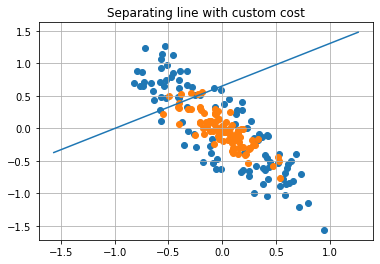

In [44]:
#Train the classifier and draw the separating line
x = np.c_[ X, np.ones(X.shape[0]) ] # add column of ones for bias
y = 3**y-2
W = np.array([-0.1, -0.2, -0.1])

Wopt = split(x, y, W)
b = Wopt[2]
m0 = Wopt[0]
m1 = Wopt[1]

#Plot
x_vals = np.linspace(x.min(),x.max(),100)
y_vals = -(m0/m1)*x_vals - b/m1

plt.scatter(x[y==-1][:,0], x[y==-1][:,1])
plt.scatter(x[y==1][:,0], x[y==1][:,1])
plt.plot(x_vals, y_vals)

plt.title('Separating line with custom cost')
plt.grid(True)
plt.show()

Note that the data above the separating line is *pure* so we don't need to worry about it any more.

In [45]:
#Make predictions
y_pred = np.dot(x, Wopt)>0
y_pred = 3**y_pred-2 #convert to +/-1

#Split the data according to the predictions
x_0 = x[y_pred==-1]
y_0 = y[y_pred==-1]
x_1 = x[y_pred==1]
y_1 = y[y_pred==1]

#Measure entropy in each subset
ent_0 = entropy1(y_0)
ent_1 = entropy1(y_1)
mean_ent = (len(y_1)*ent_1 + len(y_0)*ent_0)/(len(y_1)+len(y_0))
init_ent = entropy1(y)
print('init ent:', round(init_ent, 4))
print('ent_0:', ent_0)
print('ent_1:', round(ent_1,4))
print('mean ent:', round(mean_ent,4), '\n')

init ent: 0.6931
ent_0: 0.37677016125643675
ent_1: 0.6755
mean ent: 0.6157 



It can be seen that one of the subsets has entropy 0 so we don't need to worry about. This is the same as we saw in the graph. We have to only deal with the subset *y_1*.

Also note that the mean entropy is lower than the original entropy which indicates that the separation was effective.

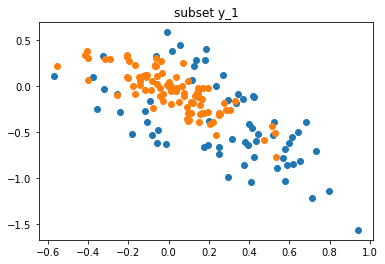

In [46]:
plt.scatter(x_1[y_1==-1][:,0], x_1[y_1==-1][:,1])
plt.scatter(x_1[y_1==1][:,0], x_1[y_1==1][:,1])
plt.title('subset y_1')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


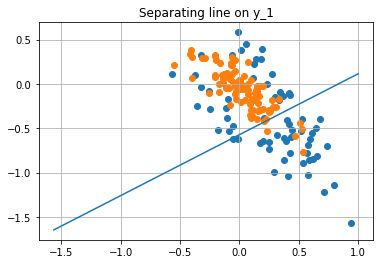

In [47]:
#Train the classifier on (x_1, y_1)
x = x_1
y = y_1

Wopt = split(x, y, W)
b = Wopt[2]
m0 = Wopt[0]
m1 = Wopt[1]

#Plot
x_vals = np.linspace(x.min(),x.max(),100)
y_vals = -(m0/m1)*x_vals - b/m1

plt.scatter(x[y==-1][:,0], x[y==-1][:,1])
plt.scatter(x[y==1][:,0], x[y==1][:,1])
plt.plot(x_vals, y_vals)

plt.title('Separating line on y_1')
plt.grid(True)
plt.show()

In [48]:
#Make predictions
y_pred = np.dot(x, Wopt)>0
y_pred = 3**y_pred-2 #convert to +/-1

#Split the data according to the predictions
x_0 = x[y_pred==-1]
y_0 = y[y_pred==-1]
x_1 = x[y_pred==1]
y_1 = y[y_pred==1]

#Measure entropy in each subset
ent_0 = entropy1(y_0)
ent_1 = entropy1(y_1)
mean_ent = (len(y_1)*ent_1 + len(y_0)*ent_0)/(len(y_1)+len(y_0))
init_ent = entropy1(y)
print('init ent:', round(init_ent, 4))
print('ent_0:', ent_0)
print('ent_1:', round(ent_1,4))
print('mean ent:', round(mean_ent,4), '\n')

init ent: 0.6755
ent_0: 0.3829604307675954
ent_1: 0.569
mean ent: 0.5237 



Note that the entropy on y_1 was 0.6689 and it is now reduced to 0.4720. It means that the separating line was effective.

Next, the subsets must continue to split recursively until some stopping criterion (e.g. entropy<0.1) is reached.

We also need to store *Wopt* from each split to be used for predictions on the test set.